In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
import preprocessing
import model
import evaluation
import pair_selection

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
if torch.cuda.is_available():
    print(f"Deploying GPU.")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. CPU will be deployed.")
    device = None

Deploying GPU.


In [3]:
# aggregated_withsolar.csv is the aggregation of all solar customers
# aggregated_withoutsolar.csv is the aggregation of all nonsolar customers
data = pd.read_csv("data/aggregated_withsolar.csv")
withoutsolar = pd.read_csv("data/aggregated_withoutsolar.csv")
data["solar"] = data["solar"].apply(lambda x: max(x, 0))

In [4]:
# Enter the number of solar customers and the number of non solar customers
num_withoutsolar = 150
num_withsolar = 172

latitude = 30.29
longitude = -97.69

In [5]:
# Define a function to estimate the scale factor
def kappa_estimation(data, withoutsolar):
    df_kappa_solar = data.loc[(data["timeofday"] >= 8) & (data["timeofday"] <= 18)]
    df_kappa_solar = df_kappa_solar[df_kappa_solar["GHI"] < 20]
    df_kappa_nonsolar = withoutsolar.loc[
        (withoutsolar["timeofday"] >= 8) & (withoutsolar["timeofday"] <= 18)
    ]
    df_kappa_nonsolar = df_kappa_nonsolar[df_kappa_nonsolar["GHI"] < 20]
    kappa = sum(df_kappa_solar["consumption"] / num_withsolar) / sum(
        df_kappa_nonsolar["consumption"] / num_withoutsolar
    )
    return kappa

In [6]:
def transform(y):
    repeat = []
    for i in range(len(y) // 2):
        repeat.append(torch.mean(y[i * 2 : (i + 1) * 2]))
    return torch.repeat_interleave(torch.stack(repeat), repeats=2, dim=0).reshape(
        len(y), 1
    )

In [7]:
# Preprocess data and estimate the scale factor
data = preprocessing.data_preprocessing(data, longitude, latitude)
kappa = kappa_estimation(data, withoutsolar)

In [8]:
data_daytime = data.loc[(data["timeofday"] >= 8) & (data["timeofday"] <= 18)]
data_daytime["minuteofyear"] = data_daytime["timeofday"] * 60 + data_daytime["minute"]

withoutsolar = withoutsolar.loc[
    (withoutsolar["timeofday"] >= 8) & (withoutsolar["timeofday"] <= 18)
]
withoutsolar["minuteofday"] = withoutsolar["timeofday"] * 60 + withoutsolar["minute"]
withoutsolar = withoutsolar.sort_values("consumption", ascending=False)

D:\Anaconda\Package\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Select training time pairs and construct the training set
target_pair_number = 250
p = pair_selection.Helper(withoutsolar)
visited = p.pair_selection(data_daytime, withoutsolar, target_pair_number)
df_training = p.training_data_constuct(data_daytime, withoutsolar)

train_data = torch.tensor(np.array(df_training, dtype=float)).to(device)
true_solar = torch.tensor(np.array(df_training.solar, dtype=float)).to(device)
train_net = torch.tensor(np.array(df_training.grid, dtype=float)).to(device)
train_net = train_net.reshape(train_net.shape[0], -1).to(device)

In [12]:
# Training
MSE = []
loss_total = []

model_train = model.PhysicalModel(latitude).to(device)
criterion = nn.MSELoss()

withoutsolar = withoutsolar.sort_values(["dayofyear", "timeofday", "minute"])
data_total = torch.tensor(np.array(data_daytime)).to(device)

train_grid = torch.tensor(np.array(data_daytime.grid, dtype=float)).to(device)
train_grid = train_grid.reshape(train_grid.shape[0], -1)

average = torch.tensor(
    list(withoutsolar["consumption"] * kappa * num_withsolar / num_withoutsolar)
).to(device)
average = average.reshape(len(average), -1)

learningRate = 0.1
epochs = 20000
optimizer = torch.optim.Adam(model_train.parameters(), lr=learningRate)

for epoch in range(epochs):

    length = len(train_data)
    y = model_train(train_data).reshape(length, 1)
    y2 = model_train(data_total).reshape(len(data_total), -1)
    y2_predict = y2 + train_grid
    y_predict = y + train_net
    ave = transform(y_predict)
    loss = (
        sum((ave.float() - y_predict.float()) ** 2)
        + sum((average.float() - y2_predict.float()) ** 2) * 0.05
    )
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_train.capacity.data = torch.clip(model_train.capacity.data, 0, 1000)
    loss_total.append(loss.cpu().detach())
    if epoch % 2000 == 0:
        print(f"Training Epochs: {epoch} Training Loss: {loss.item()}")

Training Epochs: 0 Training Loss: 11211134.0
Training Epochs: 2000 Training Loss: 7145472.0
Training Epochs: 4000 Training Loss: 4244662.0
Training Epochs: 6000 Training Loss: 2287077.5
Training Epochs: 8000 Training Loss: 1146051.0
Training Epochs: 10000 Training Loss: 666838.3125
Training Epochs: 12000 Training Loss: 578063.125
Training Epochs: 14000 Training Loss: 576209.5
Training Epochs: 16000 Training Loss: 576235.625
Training Epochs: 18000 Training Loss: 576210.0625


D:\Anaconda\Package\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


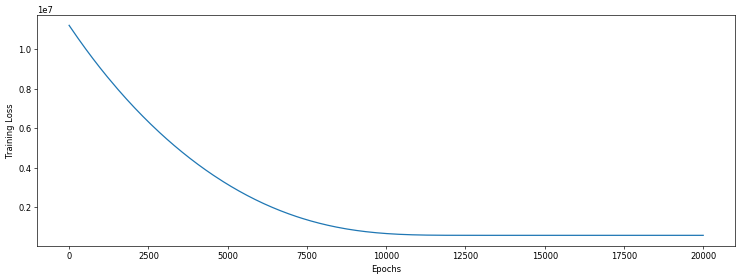

In [13]:
fig = plt.figure(figsize=(15, 5), dpi=60)
plt.plot(range(len(loss_total)), loss_total)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

In [14]:
# Define a function that does post disaggregation correction:
# if the estimated load is negative, the corresponding solar will be reestimated
def post_disaggregation_correction(data, model_train):
    data_total = torch.tensor(np.array(data)).to(device)
    data["prediction"] = model_train(data_total).cpu().detach().numpy()
    data["prediction"] = data["prediction"].apply(lambda x: max(0, x))

    col = "prediction"
    solar_corr = []
    for i in range(len(data)):
        if data.iloc[i][col] + data.iloc[i]["grid"] < 0:
            solar_corr.append(-data.iloc[i]["grid"])
        else:
            solar_corr.append(data.iloc[i][col])
    data["prediction"] = solar_corr
    data["load"] = data["prediction"] + data["grid"]

    data["load"] = data["load"].replace(0.0, np.nan)
    data["load"].interpolate(
        method="linear", limit_direction="forward", inplace=True, axis=0
    )
    data["prediction"] = data["load"] - data["grid"]
    return data

In [15]:
data = post_disaggregation_correction(data, model_train)

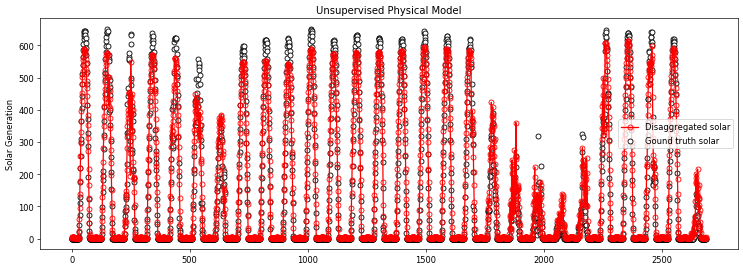

In [18]:
fig = plt.figure(figsize=(15, 5), dpi=60)
plt.scatter(range(len(data)), data.solar, marker="o", c="white", edgecolors="black")
plt.plot(
    range(len(data)),
    data.prediction,
    marker="o",
    color="red",
    markerfacecolor="none",
)
plt.ylabel("Solar Generation")
plt.title("Unsupervised Physical Model")
plt.legend(["Disaggregated solar", "Gound truth solar"])
plt.show()

In [17]:
# Evaluation the performance of this unsupervised model (on aggregated customer)
MSE, MASE, CV = evaluation.model_evaluation(data)
MSE, MASE, CV

(array([1428.34556007]), array([1.59153815]), array([0.2749497]))